# Predictive Modeling of Wind Turbine Power Generation using SCADA Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# The columns descriptions:

- Date/Time : readings for 10 minutes intervals
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- TheoreticalPowerCurve (kW): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [2]:
data = pd.read_csv(r"C:\Users\hamir\Desktop\Wind Turbine\data\T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


# Data Prep

## Renaming Columns

In [3]:
data = data.rename(columns={
    'LV ActivePower (kW)': 'power_kw',
    'Wind Speed (m/s)': 'wind_speed_ms',
    'Theoretical_Power_Curve (KWh)': 'theoretical_power_kw',
    'Wind Direction (°)': 'wind_direction_deg'
})

data

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [4]:
data.columns

Index(['Date/Time', 'power_kw', 'wind_speed_ms', 'theoretical_power_kw',
       'wind_direction_deg'],
      dtype='object')

In [5]:
data.shape

(50530, 5)

In [6]:
data.describe()

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date/Time             50530 non-null  object 
 1   power_kw              50530 non-null  float64
 2   wind_speed_ms         50530 non-null  float64
 3   theoretical_power_kw  50530 non-null  float64
 4   wind_direction_deg    50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [8]:
data.isnull().sum()

Date/Time               0
power_kw                0
wind_speed_ms           0
theoretical_power_kw    0
wind_direction_deg      0
dtype: int64

No null values

In [9]:
master_data = data.copy() #no changes done to this dataframe
df = data.copy() # to be manipulated

## Checking for outliers

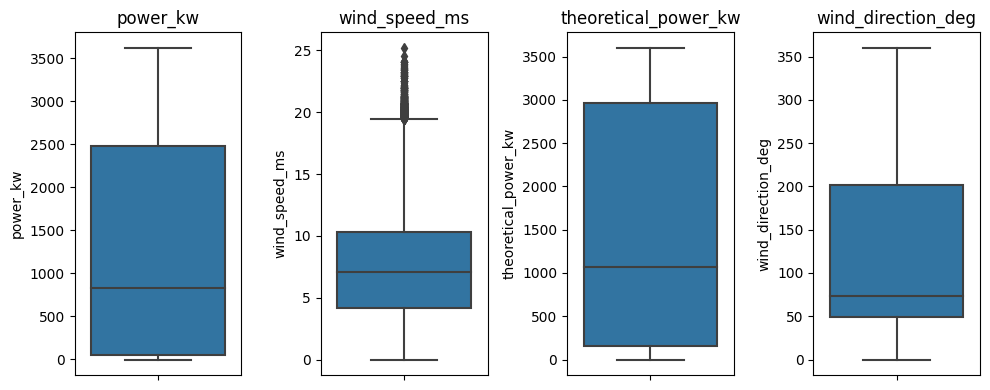

In [10]:
columns = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
i=1
plt.figure(figsize=(10,4))
for each in columns:
    plt.subplot(1,4,i)
    sns.boxplot(data = df, y= each)
    plt.title(each)
    plt.tight_layout()
    i += 1

we could see that only the column 'Wind_speed_ms' has an outlier

### Dealing with outliers

In [11]:
# checking for exact amout of outlier present
def detect_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# to remove outliers using the IQR method
def remove_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [12]:
column_names = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
for column in column_names:
    outliers = detect_outliers_IQR(df, column)
    print('Outliers for', column, ':', outliers.shape)
  

Outliers for power_kw : (0, 5)
Outliers for wind_speed_ms : (423, 5)
Outliers for theoretical_power_kw : (0, 5)
Outliers for wind_direction_deg : (0, 5)


the column Wind Speed has 423 outlier

In [13]:
outliers_wind_speed = detect_outliers_IQR(df, 'wind_speed_ms')
outliers_wind_speed['wind_speed_ms'].describe()


count    423.000000
mean      20.665708
std        1.158747
min       19.449539
25%       19.808920
50%       20.311859
75%       21.094854
max       25.206011
Name: wind_speed_ms, dtype: float64

In [14]:
print(f"The lowest wind speed within the outlier is {outliers_wind_speed['wind_speed_ms'].min()}")


The lowest wind speed within the outlier is 19.4495391845703


In [15]:
avg_power_by_out = df[(df['wind_speed_ms'] >= 19.4495391845703)]['power_kw'].mean()
print(f"Average Power Produced by outlier wind speed: {avg_power_by_out} kW")

Average Power Produced by outlier wind speed: 3571.6220905132586 kW


In [16]:
df[df['wind_speed_ms'] >= 19.4495391845703]

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
2396,17 01 2018 19:00,3460.064941,19.589029,3600.0,191.041000
2407,17 01 2018 20:50,3460.934082,20.408730,3600.0,190.896606
2408,17 01 2018 21:00,3460.278076,20.311640,3600.0,192.326599
2409,17 01 2018 21:10,3460.965088,20.203560,3600.0,194.577194
2410,17 01 2018 21:20,3461.021973,21.735920,3600.0,191.814102
...,...,...,...,...,...
49499,24 12 2018 20:10,3599.202881,20.886930,3600.0,209.078796
49500,24 12 2018 20:20,3599.352051,20.566700,3600.0,207.262207
49501,24 12 2018 20:30,3598.977051,20.452000,3600.0,206.919693
49502,24 12 2018 20:40,3599.501953,21.018150,3600.0,206.952499


### Replacing the outlier values for wind speed

#### Instead of removing all the outliers for the wind speed, any value larger than the minimum outlier value will be replace by 19 as their wind speed

In [17]:
df['wind_speed_ms'] = np.where( df['wind_speed_ms'] >= 19.4495391845703, 19, 1 * df['wind_speed_ms'] )

In [18]:
# checking if wind speed value higher than minimum outlier value still exist

df[df['wind_speed_ms'] >= 19.4495391845703]['wind_speed_ms'].count()

0

In [19]:
df[df['wind_speed_ms'] ==  19]['wind_speed_ms'].count()

423

#### 432 outlier wind speed was replaced by 19

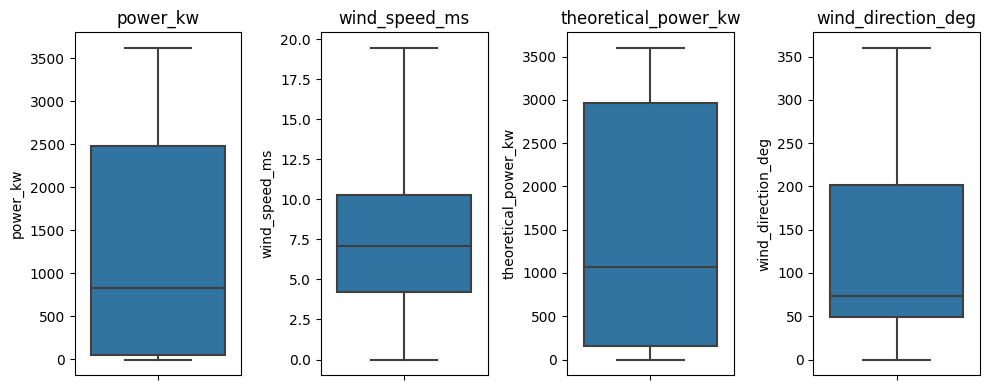

In [20]:
columns = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
i=1
plt.figure(figsize=(10,4))
for each in columns:
    plt.subplot(1,4,i)
    sns.boxplot(data = df, y= each)
    plt.title(each)
    plt.tight_layout()
    i += 1

In [21]:
column_names = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
for column in column_names:
    outliers = detect_outliers_IQR(df, column)
    print('Outliers for', column, ':', outliers.shape)

Outliers for power_kw : (0, 5)
Outliers for wind_speed_ms : (0, 5)
Outliers for theoretical_power_kw : (0, 5)
Outliers for wind_direction_deg : (0, 5)


## Dealing with date and time

In [22]:
df.head()

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [23]:
df.tail()

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620


In [24]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format= "%d %m %Y %H:%M")

df['year'] = df['Date/Time'].dt.year
df['month'] = df['Date/Time'].dt.month
df['day'] = df['Date/Time'].dt.day
df['hour'] = df['Date/Time'].dt.hour

df = df.drop(['Date/Time'], axis=1)

df.head()

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg,year,month,day,hour
0,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,419.645905,5.659674,516.127569,271.258087,2018,1,1,0
4,380.650696,5.577941,491.702972,265.674286,2018,1,1,0


In [25]:
df.tail()

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg,year,month,day,hour
50525,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23
50526,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23
50527,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23
50528,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23
50529,2820.466064,9.979332,2779.184096,82.274620,2018,12,31,23


In [34]:
import os

directory_path = r'C:\Users\hamir\Desktop\Wind Turbine\data'

file_name = os.path.join(directory_path, 'df.csv')

df.to_csv(file_name, index=False)


# EDA

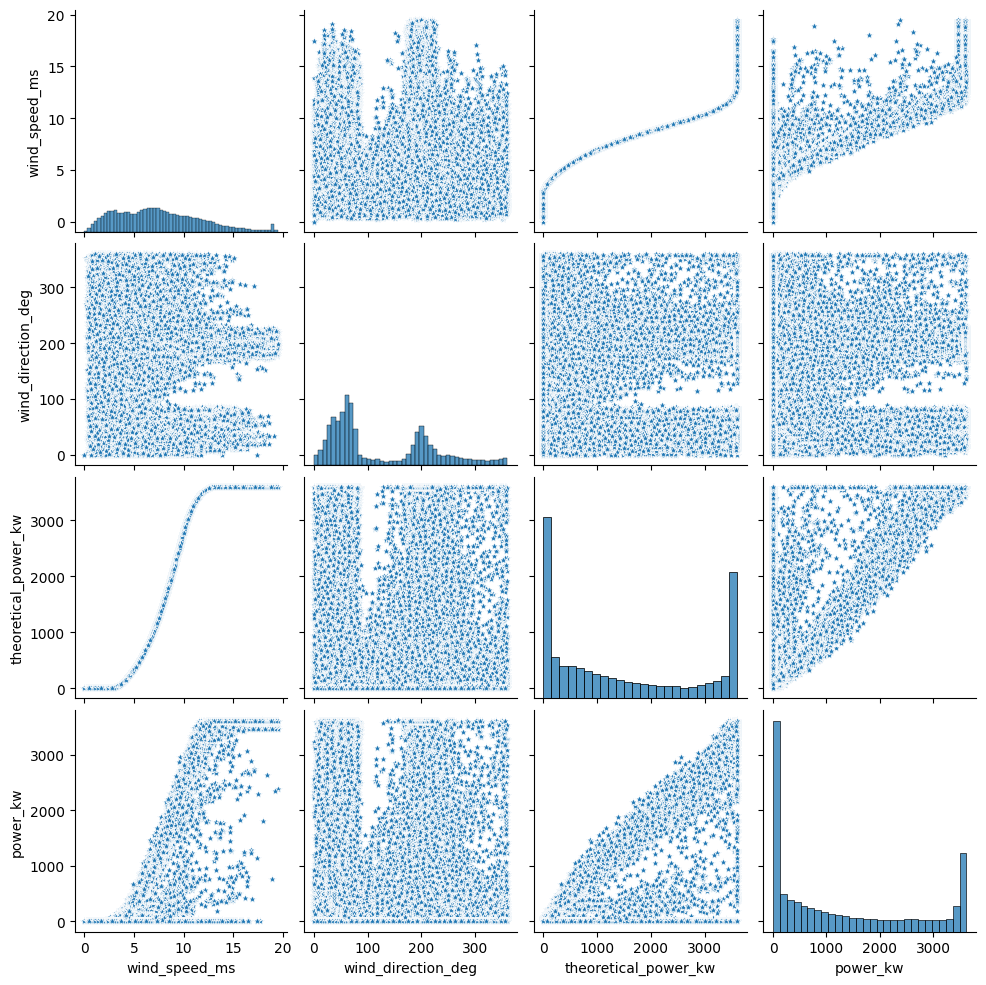

In [26]:
columns = ['wind_speed_ms', 'wind_direction_deg', 'theoretical_power_kw', 'power_kw']
sns.pairplot(df[columns], markers='*')


In [27]:
df.columns

Index(['power_kw', 'wind_speed_ms', 'theoretical_power_kw',
       'wind_direction_deg', 'year', 'month', 'day', 'hour'],
      dtype='object')

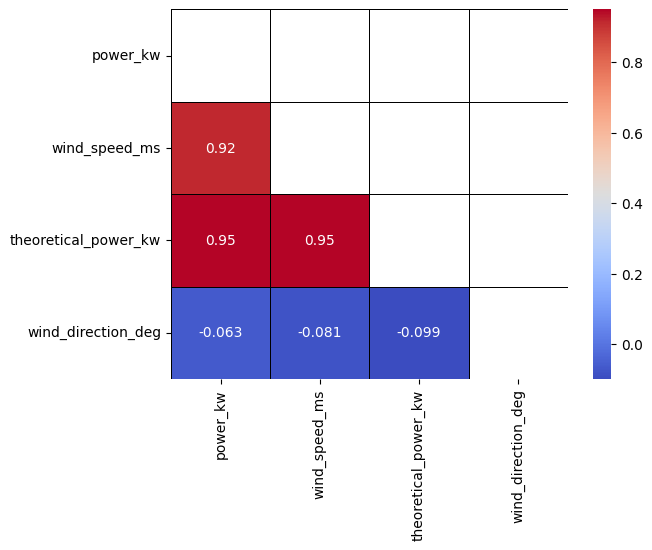

In [28]:
# Compute the correlation matrix
corr_matrix = df[['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']].corr()

# Create a boolean mask to hide the upper triangular part of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap of the correlation matrix with the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linecolor = 'black', linewidths = .5)

# Show the plot
plt.show()

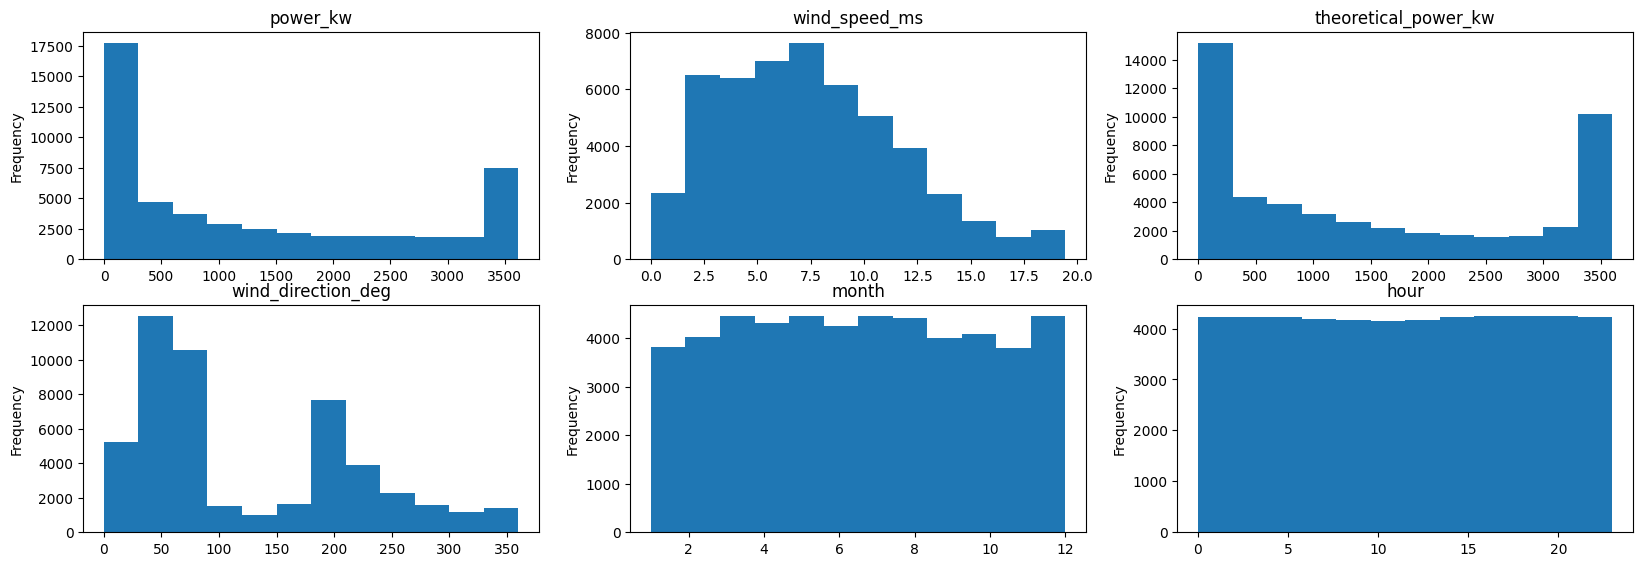

In [83]:
columns = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg', 'month', 'hour']
i=1
plt.figure(figsize=(20,6.5))
for each in columns:
    plt.subplot(2,3,i)
    df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1

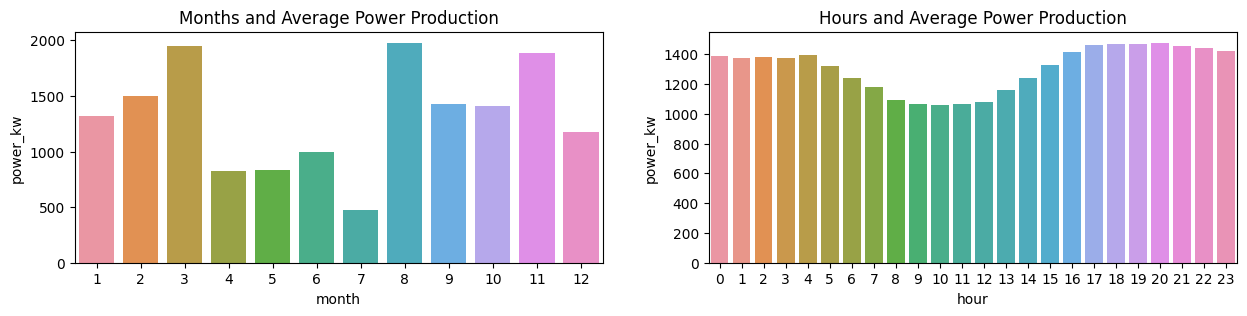

In [79]:
columns = ['month', 'hour']
i=1
plt.figure(figsize=(15,3))
for each in columns:
    avg_prod = df.groupby(each)[['power_kw']].mean().reset_index()
    plt.subplot(1,2,i)
    plt.title(f"{each.title()}s and Average Power Production")
    sns.barplot(x= each , y='power_kw', data=avg_prod)
    i += 1